In [1]:
from google.colab import files
uploaded = files.upload()


Saving Datasets.zip to Datasets.zip


In [2]:
!unzip /content/Datasets.zip -d /content/dataset_folder

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_folder/Datasets/Normal/img_0_5762.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_5762.jpg  
  inflating: /content/dataset_folder/Datasets/Normal/img_0_4695.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_4695.jpg  
  inflating: /content/dataset_folder/Datasets/Normal/img_0_808.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_808.jpg  
  inflating: /content/dataset_folder/Datasets/Normal/img_0_8905.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_8905.jpg  
  inflating: /content/dataset_folder/Datasets/Normal/img_0_4681.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_4681.jpg  
  inflating: /content/dataset_folder/Datasets/Normal/img_0_1909.jpg  
  inflating: /content/dataset_folder/__MACOSX/Datasets/Normal/._img_0_1909.jpg  
  inflating: /content/dataset_folder/Datasets

In [3]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

pcos_images_dir = "/content/dataset_folder/Datasets/PCOS_Roboflow/train/images"
pcos_labels_dir = "/content/dataset_folder/Datasets/PCOS_Roboflow/train/labels"
normal_images_dir = "/content/dataset_folder/Datasets/Normal"

dataset_dir = "/content/pcos_dataset"
splits = ['train', 'val', 'test']

for split in splits:
    os.makedirs(os.path.join(dataset_dir, split, "PCOS/images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, split, "PCOS/labels"), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, split, "Normal/images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, split, "Normal/labels"), exist_ok=True)

def get_image_files(folder):
    exts = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    files = []
    for ext in exts:
        files.extend(Path(folder).rglob(ext))
    return files

pcos_images = get_image_files(pcos_images_dir)
normal_images = get_image_files(normal_images_dir)

def split_dataset(images):
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    return train, val, test

pcos_train, pcos_val, pcos_test = split_dataset(pcos_images)
normal_train, normal_val, normal_test = split_dataset(normal_images)

def copy_data(images, split, class_name, label_dir=None, has_labels=True):
    for img_path in images:
        img_name = img_path.name
        dst_img_path = os.path.join(dataset_dir, split, class_name, "images", img_name)
        shutil.copy(str(img_path), dst_img_path)

        label_name = img_name.rsplit(".", 1)[0] + ".txt"
        dst_label_path = os.path.join(dataset_dir, split, class_name, "labels", label_name)

        if has_labels:
            src_label_path = os.path.join(label_dir, label_name)
            if os.path.exists(src_label_path):
                shutil.copy(str(src_label_path), dst_label_path)
            else:
                open(dst_label_path, "w").close()
        else:
            open(dst_label_path, "w").close()

copy_data(pcos_train, 'train', 'PCOS', pcos_labels_dir, has_labels=True)
copy_data(pcos_val, 'val', 'PCOS', pcos_labels_dir, has_labels=True)
copy_data(pcos_test, 'test', 'PCOS', pcos_labels_dir, has_labels=True)

copy_data(normal_train, 'train', 'Normal', has_labels=False)
copy_data(normal_val, 'val', 'Normal', has_labels=False)
copy_data(normal_test, 'test', 'Normal', has_labels=False)


In [4]:
import os
from pathlib import Path
from collections import defaultdict

base_path = "/content/pcos_dataset"
splits = ["train", "val", "test"]
classes = ["PCOS", "Normal"]

def count_images(base_path, splits, classes):
    count_dict = defaultdict(dict)
    for split in splits:
        for cls in classes:
            img_folder = Path(base_path) / split / cls / "images"
            img_files = list(img_folder.glob("*.[jJpP][pPnN][gG]"))
            count_dict[split][cls] = len(img_files)
    return count_dict

counts = count_images(base_path, splits, classes)

print("\nImage Count per Split and Class:\n")
for split in splits:
    print(f"{split.upper()} SET")
    for cls in classes:
        print(f"  {cls:<6}: {counts[split][cls]} images")



Image Count per Split and Class:

TRAIN SET
  PCOS  : 545 images
  Normal: 799 images
VAL SET
  PCOS  : 117 images
  Normal: 171 images
TEST SET
  PCOS  : 117 images
  Normal: 172 images


In [5]:
!pip install -q ultralytics
import os
from ultralytics import YOLO
train_dir = "/content/pcos_dataset/train"
val_dir = "/content/pcos_dataset/val"

data_yaml = f"""
train: {train_dir}
val: {val_dir}

nc: 1
names: ['follicle']
"""

yaml_path = "/content/pcos_dataset/pcos_data.yaml"
with open(yaml_path, 'w') as f:
    f.write(data_yaml)

model = YOLO('yolov8n.pt')
model.train(data=yaml_path, epochs=15, imgsz=640, batch=16, lr0=0.001, cos_lr=True, patience=20, optimizer='SGD', single_cls=True, cls=0.5, mosaic=1.0, mixup=0.2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

100%|██████████| 6.25M/6.25M [00:00<00:00, 74.5MB/s]


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/pcos_dataset/pcos_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, po

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7    

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 67.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 874.4±463.6 MB/s, size: 40.8 KB)


train: Scanning /content/pcos_dataset/train/Normal/labels... 1345 images, 800 backgrounds, 0 corrupt: 100%|██████████| 1345/1345 [00:00<00:00, 1909.69it/s]

train: /content/pcos_dataset/train/PCOS/images/img_0_54_jpg.rf.e34f259f4734255a9a738646182bd7e7.jpg: 2 duplicate labels removed
train: New cache created: /content/pcos_dataset/train/Normal/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 371.7±127.8 MB/s, size: 17.0 KB)


val: Scanning /content/pcos_dataset/val/Normal/labels... 288 images, 171 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:00<00:00, 1554.23it/s]


val: New cache created: /content/pcos_dataset/val/Normal/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15       2.2G      2.333      3.529      1.924          0        640: 100%|██████████| 85/85 [00:09<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all        288       1389     0.0136      0.843      0.239      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.85G      2.211      2.356      1.972          2        640: 100%|██████████| 85/85 [00:07<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]

                   all        288       1389      0.672      0.681      0.652      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.87G       2.13          2      1.981          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.67it/s]


                   all        288       1389      0.743      0.691      0.703      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.88G      2.054      1.827      1.832          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.33it/s]


                   all        288       1389      0.751      0.698      0.743      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       2.9G      2.051      1.669      1.752         19        640: 100%|██████████| 85/85 [00:07<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.90it/s]


                   all        288       1389      0.742      0.695      0.755      0.305
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.91G      1.981      1.766       1.75          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.75it/s]


                   all        288       1389      0.825       0.73      0.795      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.92G      1.957      1.677      1.711          0        640: 100%|██████████| 85/85 [00:06<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


                   all        288       1389      0.817      0.727       0.81      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.92G      1.963      1.648      1.729          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


                   all        288       1389      0.815      0.742       0.81      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.94G      2.001      1.584      1.734         11        640: 100%|██████████| 85/85 [00:07<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


                   all        288       1389      0.822      0.767      0.821       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.96G      1.962      1.512      1.699         12        640: 100%|██████████| 85/85 [00:06<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


                   all        288       1389      0.828      0.757       0.82      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.97G      1.963       1.51      1.687         15        640: 100%|██████████| 85/85 [00:07<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


                   all        288       1389      0.824      0.751      0.818      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.97G      1.935      1.528      1.683          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.77it/s]


                   all        288       1389      0.826       0.75      0.823      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.99G      1.937      1.474      1.667         11        640: 100%|██████████| 85/85 [00:07<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.13it/s]


                   all        288       1389       0.83      0.764      0.828      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         3G      1.933      1.502      1.678          0        640: 100%|██████████| 85/85 [00:06<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.01it/s]


                   all        288       1389      0.826      0.754      0.822      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      3.01G      1.912      1.517      1.655          0        640: 100%|██████████| 85/85 [00:07<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


                   all        288       1389      0.814       0.76      0.821       0.36

15 epochs completed in 0.037 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


                   all        288       1389      0.818       0.76      0.821      0.359
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bab34aa1950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

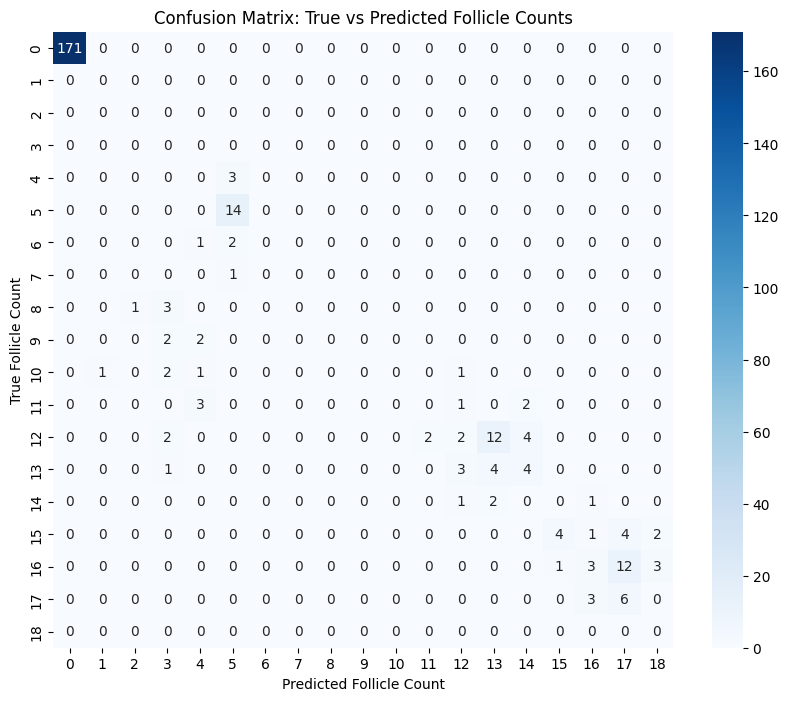


Evaluation Metrics for Follicle Count Prediction:
Mean Squared Error (MSE): 3.48
Mean Absolute Error (MAE): 0.73
Root Mean Squared Error (RMSE): 1.87
R² Score: 0.91


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/best.pt')

val_pcos_images = list(Path('/content/pcos_dataset/val/PCOS/images').rglob('*.jpg'))
val_normal_images = list(Path('/content/pcos_dataset/val/Normal/images').rglob('*.jpg'))

results = []

def predict_follicle_count(img_path):
    preds = model.predict(str(img_path), conf=0.25, iou=0.45, verbose=False)
    if preds and len(preds[0].boxes) > 0:
        return len(preds[0].boxes)
    return 0

for img_path in val_pcos_images:
    results.append({
        "image_path": img_path,
        "true_label": "PCOS",
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

for img_path in val_normal_images:
    results.append({
        "image_path": img_path,
        "true_label": "Normal",
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

df_results = pd.DataFrame(results)

def get_true_follicle_count_from_label(img_path):
    label_path = str(img_path).replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            return len(f.readlines())
    return 0

df_results["true_follicle_count"] = df_results["image_path"].apply(get_true_follicle_count_from_label)

max_count = max(df_results["true_follicle_count"].max(), df_results["predicted_follicle_count"].max())
labels_exact = list(range(max_count + 1))

cm_counts = confusion_matrix(
    df_results["true_follicle_count"],
    df_results["predicted_follicle_count"],
    labels=labels_exact
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_counts, annot=True, fmt="d", cmap="Blues",
             xticklabels=labels_exact, yticklabels=labels_exact)
plt.xlabel("Predicted Follicle Count")
plt.ylabel("True Follicle Count")
plt.title("Confusion Matrix: True vs Predicted Follicle Counts")
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
y_true = df_results["true_follicle_count"]
y_pred = df_results["predicted_follicle_count"]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\nEvaluation Metrics for Follicle Count Prediction:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Accuracy on Validation Set: 1.0000

Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       171
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



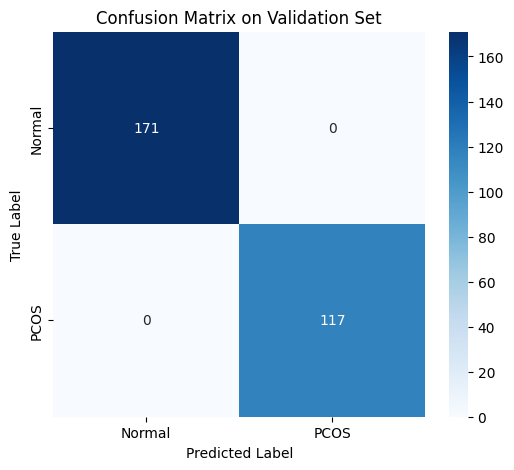

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

df_results["true_label"] = df_results["true_follicle_count"].apply(lambda x: "PCOS" if x > 0 else "Normal")
df_results["predicted_label"] = df_results["predicted_follicle_count"].apply(lambda x: "PCOS" if x > 0 else "Normal")

accuracy = accuracy_score(df_results["true_label"], df_results["predicted_label"])
print(f"Accuracy on Validation Set: {accuracy:.4f}\n")

print("Classification Report:\n")
print(classification_report(df_results["true_label"], df_results["predicted_label"]))

cm = confusion_matrix(df_results["true_label"], df_results["predicted_label"], labels=["Normal", "PCOS"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "PCOS"], yticklabels=["Normal", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [ ]:
#test 1

Accuracy on Test Set: 1.0000

Classification Report on Test Set:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       172
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



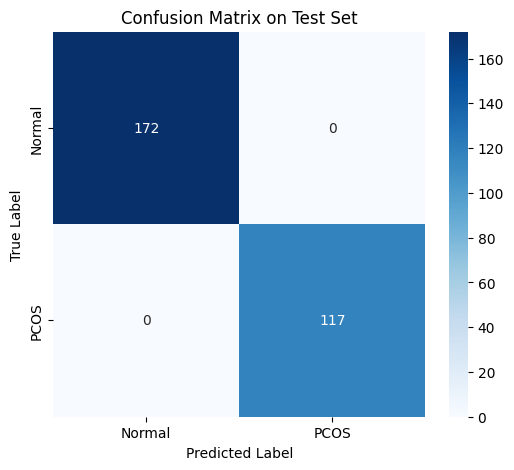

In [8]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

model = YOLO('/content/runs/detect/train/weights/best.pt')

test_pcos_images = list(Path('/content/pcos_dataset/test/PCOS/images').rglob('*.jpg'))
test_normal_images = list(Path('/content/pcos_dataset/test/Normal/images').rglob('*.jpg'))

results_test = []

def predict_follicle_count(img_path):
    preds = model.predict(str(img_path), conf=0.25, iou=0.45, verbose=False)
    return len(preds[0].boxes) if preds and len(preds[0].boxes) > 0 else 0

def get_true_follicle_count(img_path):
    label_path = str(img_path).replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            return len(f.readlines())
    return 0

for img_path in test_pcos_images:
    results_test.append({
        "image_path": str(img_path),
        "true_follicle_count": get_true_follicle_count(img_path),
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

for img_path in test_normal_images:
    results_test.append({
        "image_path": str(img_path),
        "true_follicle_count": get_true_follicle_count(img_path),
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

df_test = pd.DataFrame(results_test)

df_test["true_label"] = df_test["true_follicle_count"].apply(lambda x: "PCOS" if x > 0 else "Normal")
df_test["predicted_label"] = df_test["predicted_follicle_count"].apply(lambda x: "PCOS" if x > 0 else "Normal")

accuracy_test = accuracy_score(df_test["true_label"], df_test["predicted_label"])
print(f"Accuracy on Test Set: {accuracy_test:.4f}\n")

print("Classification Report on Test Set:\n")
print(classification_report(df_test["true_label"], df_test["predicted_label"]))

cm_test = confusion_matrix(df_test["true_label"], df_test["predicted_label"], labels=["Normal", "PCOS"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "PCOS"], yticklabels=["Normal", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


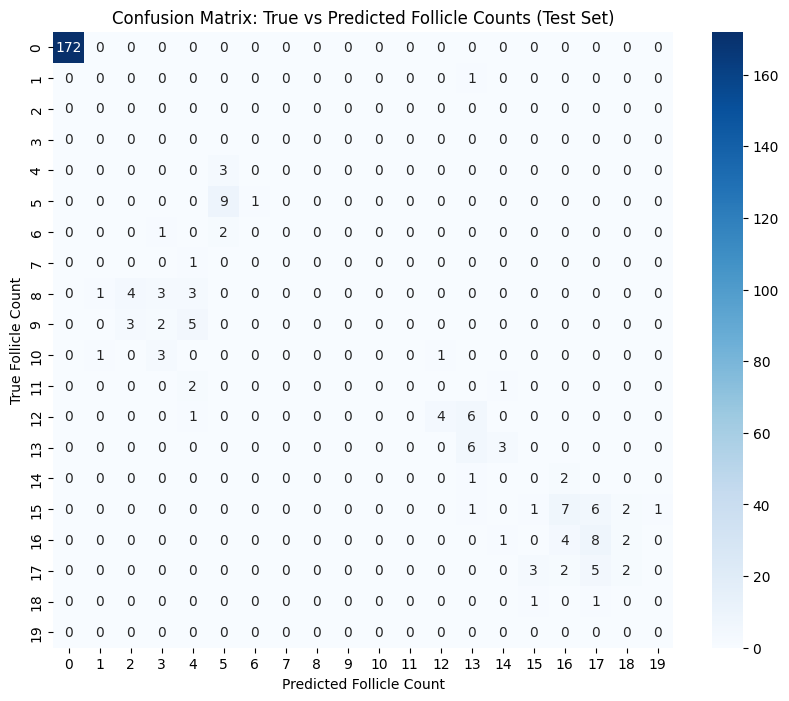


Evaluation Metrics for Follicle Count Prediction (Test Set):
Mean Squared Error (MSE): 4.72
Mean Absolute Error (MAE): 0.93
Root Mean Squared Error (RMSE): 2.17
R² Score: 0.88


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/best.pt')

test_pcos_images = list(Path('/content/pcos_dataset/test/PCOS/images').rglob('*.jpg'))
test_normal_images = list(Path('/content/pcos_dataset/test/Normal/images').rglob('*.jpg'))

results_test = []

def predict_follicle_count(img_path):
    preds = model.predict(str(img_path), conf=0.25, iou=0.45, verbose=False)
    return len(preds[0].boxes) if preds and len(preds[0].boxes) > 0 else 0

def get_true_follicle_count_from_label(img_path):
    label_path = str(img_path).replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            return len(f.readlines())
    return 0

for img_path in test_pcos_images:
    results_test.append({
        "image_path": str(img_path),
        "true_label": "PCOS",
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

for img_path in test_normal_images:
    results_test.append({
        "image_path": str(img_path),
        "true_label": "Normal",
        "predicted_follicle_count": predict_follicle_count(img_path)
    })

df_test = pd.DataFrame(results_test)

df_test["true_follicle_count"] = df_test["image_path"].apply(get_true_follicle_count_from_label)

max_count = max(df_test["true_follicle_count"].max(), df_test["predicted_follicle_count"].max())
labels_exact = list(range(max_count + 1))

cm_counts = confusion_matrix(
    df_test["true_follicle_count"],
    df_test["predicted_follicle_count"],
    labels=labels_exact
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_counts, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_exact, yticklabels=labels_exact)
plt.xlabel("Predicted Follicle Count")
plt.ylabel("True Follicle Count")
plt.title("Confusion Matrix: True vs Predicted Follicle Counts (Test Set)")
plt.show()

y_true = df_test["true_follicle_count"]
y_pred = df_test["predicted_follicle_count"]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\nEvaluation Metrics for Follicle Count Prediction (Test Set):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


In [ ]:
#test 2

In [10]:
import zipfile
from google.colab import files

uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/test_data")


Saving Testing.zip to Testing.zip


In [11]:
!pip install pyheif

import pyheif
from PIL import Image
import os
from pathlib import Path

def convert_images_to_png(input_folder):
    image_files = (
        list(Path(input_folder).rglob("*.[hH][eE][iI][cC]")) +
        list(Path(input_folder).rglob("*.[jJ][pP][gG]")) +
        list(Path(input_folder).rglob("*.[jJ][pP][eE][gG]"))
    )

    for img_path in image_files:
        ext = img_path.suffix.lower()
        try:
            if ext == '.heic':
                heif_file = pyheif.read(str(img_path))
                image = Image.frombytes(
                    heif_file.mode, heif_file.size, heif_file.data,
                    "raw", heif_file.mode, heif_file.stride,
                )
            elif ext in ['.jpg', '.jpeg']:
                image = Image.open(str(img_path))
            else:
                continue

            out_path = img_path.with_suffix(".png")
            image.save(out_path)
            print(f"Converted: {img_path.name} to {out_path.name}")
            os.remove(img_path)

        except Exception as e:
            print(f"Error converting {img_path.name}: {e}")

convert_images_to_png("/content/test_data/Testing/Normal")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.6 MB/s eta 0:00:00
Converted: norm8.heic to norm8.png
Converted: norm3.heic to norm3.png
Converted: norm2.heic to norm2.png
Converted: norm9.heic to norm9.png
Converted: norm1.heic to norm1.png
Converted: norm11.jpeg to norm11.png
Converted: norm10.jpeg to norm10.png
Converted: norm7.jpeg to norm7.png
Converted: norm12.jpeg to norm12.png


In [12]:
from PIL import Image
import os
from pathlib import Path

def convert_pcos_images_to_png(input_folder):
    jpg_files = list(Path(input_folder).rglob("*.jpg")) + list(Path(input_folder).rglob("*.jpeg"))

    for img_path in jpg_files:
        try:
            image = Image.open(str(img_path))
            out_path = img_path.with_suffix(".png")
            image.save(out_path)
            print(f"Converted: {img_path.name} to {out_path.name}")
            os.remove(img_path)  # remove original .jpg/.jpeg
        except Exception as e:
            print(f"Error converting {img_path.name}: {e}")

convert_pcos_images_to_png("/content/test_data/Testing/PCOS_Roboflow_Testing/test/images")


Converted: pcos1_png.rf.a988f3aec1786d7249034124cf780316.jpg to pcos1_png.rf.a988f3aec1786d7249034124cf780316.png
Converted: pcos13_jpg.rf.db5ccd31e459914161c15e660e0a2126.jpg to pcos13_jpg.rf.db5ccd31e459914161c15e660e0a2126.png
Converted: pcos5_png.rf.5f4736b240ff40dba727ee275856e45d.jpg to pcos5_png.rf.5f4736b240ff40dba727ee275856e45d.png
Converted: pcos12_jpg.rf.4d5d252739c0a3ffbbc1701e21d0e320.jpg to pcos12_jpg.rf.4d5d252739c0a3ffbbc1701e21d0e320.png
Converted: pcos14_jpg.rf.64ecce1bb7405d25534de2a21d42b6aa.jpg to pcos14_jpg.rf.64ecce1bb7405d25534de2a21d42b6aa.png
Converted: pcos9_jpg.rf.c397ffcd91d4ff29fd72684ac851d907.jpg to pcos9_jpg.rf.c397ffcd91d4ff29fd72684ac851d907.png
Converted: pcos4_png.rf.17c9116864b0952a091a0a651718618a.jpg to pcos4_png.rf.17c9116864b0952a091a0a651718618a.png
Converted: pcos8_jpg.rf.9dff9bbe6f8eeb08a84338f44e819108.jpg to pcos8_jpg.rf.9dff9bbe6f8eeb08a84338f44e819108.png
Converted: pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99.jpg to pcos10_jpg.rf.b91

In [13]:
import albumentations as A
import cv2
import os
import shutil
from pathlib import Path

shutil.rmtree('/content/augmented/PCOS/images', ignore_errors=True)
shutil.rmtree('/content/augmented/PCOS/labels', ignore_errors=True)
shutil.rmtree('/content/augmented/Normal/images', ignore_errors=True)
os.makedirs('/content/augmented/PCOS/images', exist_ok=True)
os.makedirs('/content/augmented/PCOS/labels', exist_ok=True)
os.makedirs('/content/augmented/Normal/images', exist_ok=True)

transform_with_labels = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=15, p=0.7),
    A.CLAHE(clip_limit=2.0, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Equalize(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5)

], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

def augment_images_with_labels(input_img_dir, input_lbl_dir, output_img_dir, output_lbl_dir, augmentations_per_image=5):
    image_paths = sorted(list(Path(input_img_dir).rglob('*.png')))
    for img_path in image_paths:
        base_name = img_path.stem
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_file = Path(input_lbl_dir) / f"{base_name}.txt"
        bboxes, category_ids = [], []
        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        category_ids.append(int(parts[0]))
                        bboxes.append([float(p) for p in parts[1:]])

        cv2.imwrite(os.path.join(output_img_dir, base_name + ".png"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        if bboxes:
            with open(os.path.join(output_lbl_dir, base_name + ".txt"), 'w') as f:
                for cid, bbox in zip(category_ids, bboxes):
                    f.write(f"{cid} {' '.join(map(str, bbox))}\n")

        for i in range(augmentations_per_image):
            augmented = transform_with_labels(image=image, bboxes=bboxes, category_ids=category_ids)
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_name = f"{base_name}_aug{i}"
            cv2.imwrite(os.path.join(output_img_dir, f"{aug_name}.png"), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            if aug_bboxes:
                with open(os.path.join(output_lbl_dir, f"{aug_name}.txt"), 'w') as f:
                    for cid, bbox in zip(category_ids, aug_bboxes):
                        f.write(f"{cid} {' '.join(map(str, bbox))}\n")

transform_without_labels = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=15, p=0.7),
    A.CLAHE(clip_limit=2.0, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Equalize(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5)

])

def augment_images_without_labels(input_img_dir, output_img_dir, augmentations_per_image=5):
    image_paths = sorted(list(Path(input_img_dir).rglob('*.png')))
    for img_path in image_paths:
        base_name = img_path.stem
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        cv2.imwrite(os.path.join(output_img_dir, base_name + ".png"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        for i in range(augmentations_per_image):
            augmented = transform_without_labels(image=image)
            aug_image = augmented['image']
            aug_name = f"{base_name}_aug{i}"
            cv2.imwrite(os.path.join(output_img_dir, f"{aug_name}.png"), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

augment_images_with_labels(
    '/content/test_data/Testing/PCOS_Roboflow_Testing/test/images',
    '/content/test_data/Testing/PCOS_Roboflow_Testing/test/labels',
    '/content/augmented/PCOS/images',
    '/content/augmented/PCOS/labels',
    augmentations_per_image=5
)

augment_images_without_labels(
    '/content/test_data/Testing/Normal',
    '/content/augmented/Normal/images',
    augmentations_per_image=8  )

pcos_augmented_images = list(Path('/content/augmented/PCOS/images').rglob('*.png'))
normal_augmented_images = list(Path('/content/augmented/Normal/images').rglob('*.png'))

print(f"Total Final Augmented PCOS Images: {len(pcos_augmented_images)}")
print(f"Total Final Augmented Normal Images: {len(normal_augmented_images)}")


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Total Final Augmented PCOS Images: 90
Total Final Augmented Normal Images: 108


In [14]:
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/best.pt')

def get_true_follicle_counts(label_dir):
    true_counts = []
    label_paths = sorted(list(Path(label_dir).rglob('*.txt')))
    for lbl_path in label_paths:
        with open(lbl_path, 'r') as f:
            count = len(f.readlines())
            true_counts.append(count)
    return true_counts

def interpret_follicle_count(count):
    if count == 0:
        return "Normal Ovarian Reserve (No abnormalities detected)"
    elif 1 <= count <= 4:
        return "Very Low Ovarian Reserve"
    elif 5 <= count <= 7:
        return "Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)"
    elif 8 <= count <= 14:
        return "Normal Ovarian Reserve"
    else:
        return "High Ovarian Reserve (Possible Risk of OHSS)"

def run_inference(image_dir, true_label, true_follicle_counts=None):
    results_list = []
    image_paths = sorted(list(Path(image_dir).rglob('*.png')))

    for idx, img_path in enumerate(image_paths):
        results = model.predict(str(img_path), conf=0.3, iou=0.45, verbose=False)
        pred_count = len(results[0].boxes) if results else 0
        predicted_label = "PCOS" if pred_count > 0 else "Normal"
        true_count = true_follicle_counts[idx] if true_follicle_counts else 0

        interpretation = interpret_follicle_count(pred_count)

        results_list.append({
            "image": str(img_path),
            "true_label": true_label,
            "predicted_label": predicted_label,
            "true_follicle_count": true_count,
            "predicted_follicle_count": pred_count,
            "medical_interpretation": interpretation
        })
    return results_list

pcos_image_path = "/content/augmented/PCOS/images"
normal_image_path = "/content/augmented/Normal/images"
pcos_label_path = "/content/augmented/PCOS/labels"

pcos_true_follicle_counts = get_true_follicle_counts(pcos_label_path)
pcos_results = run_inference(pcos_image_path, "PCOS", pcos_true_follicle_counts)
normal_results = run_inference(normal_image_path, "Normal")

df_results = pd.DataFrame(pcos_results + normal_results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(df_results)

df_results.to_excel("/content/final_test_results_follicle_count.xlsx", index=False)


,image,true_label,predicted_label,true_follicle_count,predicted_follicle_count,medical_interpretation
0,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99.png,PCOS,PCOS,7,6,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
1,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99_aug0.png,PCOS,PCOS,7,6,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
2,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99_aug1.png,PCOS,PCOS,7,6,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
3,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99_aug2.png,PCOS,PCOS,7,6,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
4,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99_aug3.png,PCOS,PCOS,7,5,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
5,/content/augmented/PCOS/images/pcos10_jpg.rf.b911210a66e1794bf7a6775fd8f79b99_aug4.png,PCOS,PCOS,7,7,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
6,/content/augmented/PCOS/images/pcos11_jpg.rf.48d997fd8dcaccac8d815fb91f6ff81c.png,PCOS,PCOS,8,7,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
7,/content/augmented/PCOS/images/pcos11_jpg.rf.48d997fd8dcaccac8d815fb91f6ff81c_aug0.png,PCOS,PCOS,8,5,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
8,/content/augmented/PCOS/images/pcos11_jpg.rf.48d997fd8dcaccac8d815fb91f6ff81c_aug1.png,PCOS,PCOS,8,5,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)
9,/content/augmented/PCOS/images/pcos11_jpg.rf.48d997fd8dcaccac8d815fb91f6ff81c_aug2.png,PCOS,PCOS,8,7,Low Ovarian Reserve (Diminished Ovarian Reserve - DOR)


Accuracy on Test Set: 0.9899

Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       108
        PCOS       0.99      0.99      0.99        90

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198



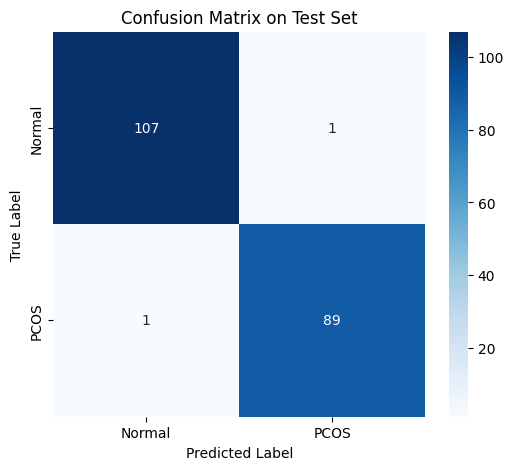

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(df_results["true_label"], df_results["predicted_label"])
print(f"Accuracy on Test Set: {accuracy:.4f}\n")

print("Classification Report:\n")
print(classification_report(df_results["true_label"], df_results["predicted_label"]))

cm = confusion_matrix(df_results["true_label"], df_results["predicted_label"], labels=["Normal", "PCOS"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "PCOS"], yticklabels=["Normal", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


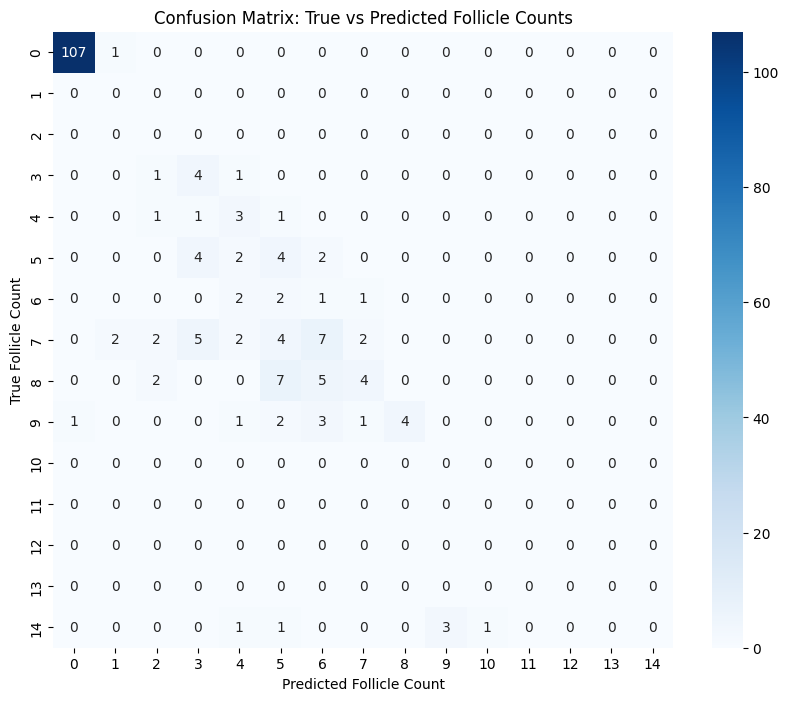

Evaluation Metrics for Follicle Count Prediction:

Mean Squared Error (MSE): 4.48
Mean Absolute Error (MAE): 1.07
R² Score: 0.71
Root Mean Squared Error (RMSE): 2.12


In [16]:
max_true_count = df_results["true_follicle_count"].max()
max_pred_count = df_results["predicted_follicle_count"].max()
max_count = max(max_true_count, max_pred_count)

labels_range = list(range(0, max_count + 1))

cm_counts = confusion_matrix(
    df_results["true_follicle_count"],
    df_results["predicted_follicle_count"],
    labels=labels_range
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_counts, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Follicle Count")
plt.ylabel("True Follicle Count")
plt.title("Confusion Matrix: True vs Predicted Follicle Counts")
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = df_results["true_follicle_count"]
y_pred = df_results["predicted_follicle_count"]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Evaluation Metrics for Follicle Count Prediction:\n")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [ ]:
#test 3

Saving Figure-2.jpg to Figure-2.jpg

image 1/1 /content/Figure-2.png: 576x640 13 items, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)

Image 'Figure-2.jpg' classified as: PCOS with 13 follicles detected.


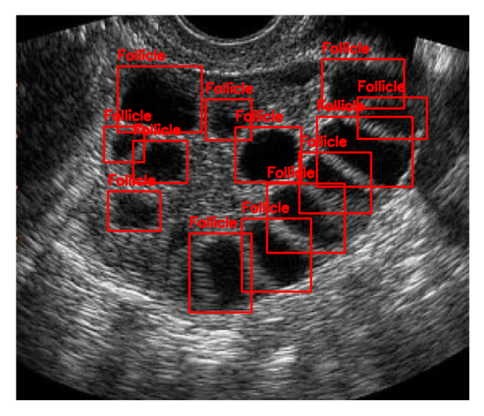

In [17]:
from google.colab import files
import os
import pyheif
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

model = YOLO('/content/runs/detect/train/weights/best.pt')

uploaded = files.upload()

def convert_to_png(input_path):
    ext = os.path.splitext(input_path)[1].lower()
    output_path = input_path.rsplit('.', 1)[0] + ".png"
    try:
        if ext in ['.heic', '.heif']:
            heif_file = pyheif.read(input_path)
            image = Image.frombytes(
                heif_file.mode,
                heif_file.size,
                heif_file.data,
                "raw",
                heif_file.mode,
                heif_file.stride,
            )
        else:
            image = Image.open(input_path)
        image.save(output_path, "PNG")
        return output_path
    except Exception as e:
        print(f"Error during conversion: {e}")
        return None

def classify_and_count(image_path):
    if not os.path.exists(image_path):
        print(f"File {image_path} does not exist.")
        return "Unknown", 0, None

    if not image_path.lower().endswith('.png'):
        image_path = convert_to_png(image_path)
        if image_path is None:
            return "Unknown", 0, None

    results = model.predict(image_path, conf=0.25, iou=0.45)
    count = len(results[0].boxes) if results else 0
    label = "PCOS" if count > 0 else "Normal"
    return label, count, results

def plot_yolo_detections(image_path, results, font_scale=0.7):
    image = cv2.imread(image_path)
    annotator = Annotator(image, line_width=2)
    for box in results[0].boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        annotator.box_label(xyxy, "", color=(0, 0, 255))
        x1, y1, _, _ = xyxy
        cv2.putText(image, "Follicle", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    annotated_image = annotator.result()
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

for filename in uploaded.keys():
    label, count, results = classify_and_count(filename)
    print(f"\nImage '{filename}' classified as: {label} with {count} follicles detected.")

    final_image_path = filename
    if not final_image_path.lower().endswith('.png'):
        final_image_path = convert_to_png(final_image_path)

    if final_image_path and results:
        plot_yolo_detections(final_image_path, results)
